In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


data_file = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [2]:
df_ru = data_file.parse(0)
df_tur = data_file.parse(1)
df_eg = data_file.parse(2)
df_bra = data_file.parse(3)
df_arg = data_file.parse(4)
df_col = data_file.parse(5)
df_sa = data_file.parse(6)
df_sk = data_file.parse(7)

In [3]:
df_bra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      310 non-null    object 
 1   Price     310 non-null    object 
 2   Open      310 non-null    object 
 3   High      310 non-null    object 
 4   Low       310 non-null    object 
 5   Vol.      309 non-null    object 
 6   Change %  309 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.1+ KB


In [4]:
def timeseries_preprocessing(df):
    #Drop the last row of the dataframe
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Search if there is K instead of M in volume colum
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    
    #replace with K with nothing and change it to numeric value
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    
    # convert it to M by dividing it by 1000
    k_data['Vol.'] = [(i/1000) for i in k_data['Vol.']]
    
    #join the two dataframe
    df = pd.concat([df, k_data], join="inner")
    
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    
    # make the index equal to Date values
    df = df.sort_values(by=['Date'], ascending=True)  
    
    df = df.drop(columns =['Vol.','Change %'])

    return df

# Brazil Minerva SABrazil Stocks

In [5]:
df = timeseries_preprocessing(df_bra)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 308 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    309 non-null    datetime64[ns]
 1   Price   309 non-null    float64       
 2   Open    309 non-null    float64       
 3   High    309 non-null    float64       
 4   Low     309 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.5 KB


In [6]:
def timeseries_plot(df):
    indexed_dataset = df.set_index('Date')
    indexed_dataset[['Price','Open','High','Low']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Values($)',fontsize=20);
    plt.title('Timeseries Plot of High, Low, Open, Closing Price of Stocks',fontsize = 20)
    plt.show() 

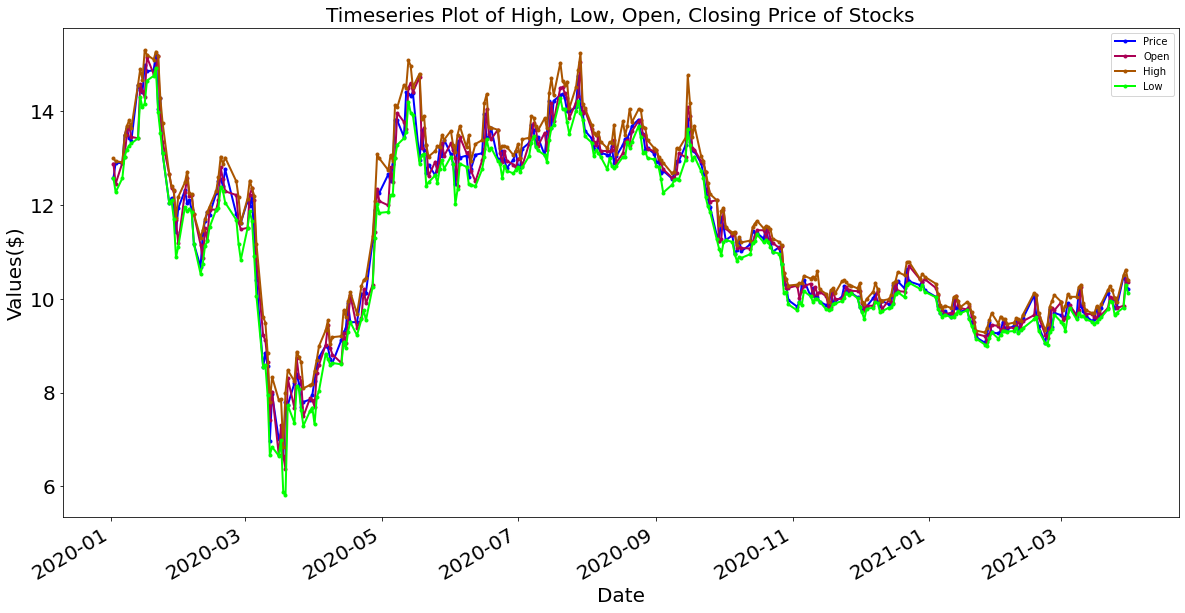

In [7]:
timeseries_plot(df)

In [8]:
def timeseries_plot_closing_value(df):
    
    indexed_dataset = df.set_index('Date')
    indexed_dataset['Price'].plot(figsize=(12,5))
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Closing Value($)',fontsize=20);
    plt.title('Timeseries of closing stock Price',fontsize = 20)
    plt.show()
    

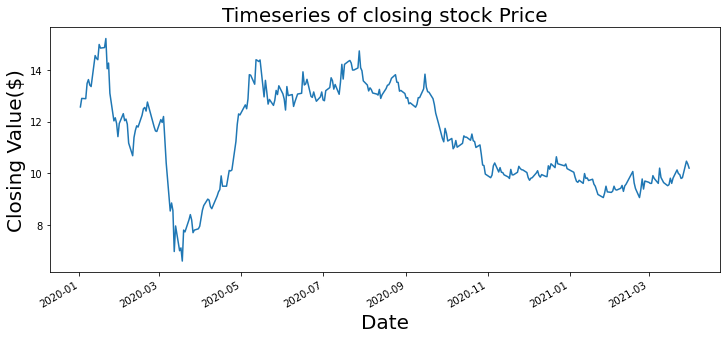

In [9]:
timeseries_plot_closing_value(df)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def acf_pacf_plot(df):
    indexed_dataset = df.set_index('Date')
    df_close= indexed_dataset['Price']
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df_close,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df_close,lags=20,ax=ax2)


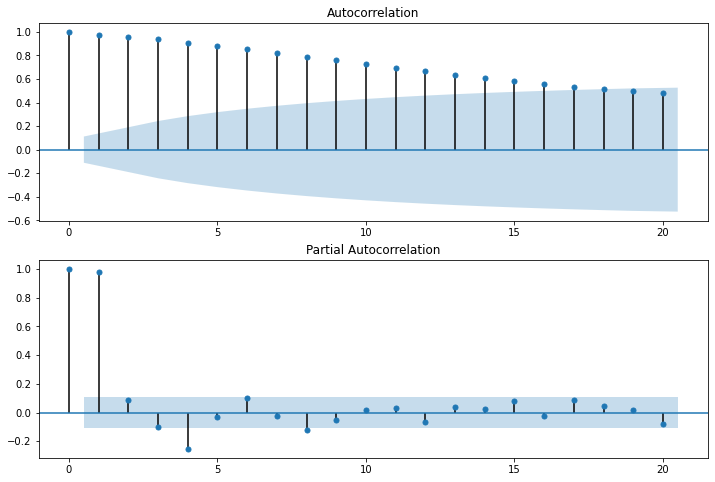

In [11]:
acf_pacf_plot(df)

# Dickey Fuller Test

In [12]:
#If the dataset is not stationary--

def stationary(df):
    result = adfuller(df.Price.values, autolag='AIC')
    if result[1] > 0.05:
        print(f'The p-value is {result[1]} reject the null hypthesis and data is not stationary')
        result = adfuller(np.diff(df.Price.values), autolag='AIC')
    if result[1] < 0.05:
        print(f'The p-value after first difference is {result[1]}, accept the null hypothesis and data is stationary')
        difference = df.Price.diff()
        df['Difference'] = difference
    else:
        print('Your time series is not stationary, you may need to make another difference')
    return df

In [13]:
df = stationary(df)

The p-value is 0.18390623701557407 reject the null hypthesis and data is not stationary
The p-value after first difference is 6.858473426851321e-13, accept the null hypothesis and data is stationary


In [14]:
df = df.dropna()
df

,Date,Price,Open,High,Low,Difference
307,2020-01-03,12.90,12.45,12.93,12.27,0.33
306,2020-01-06,12.89,12.90,12.91,12.57,-0.01
305,2020-01-07,13.48,13.03,13.48,13.03,0.59
304,2020-01-08,13.63,13.50,13.68,13.18,0.15
303,2020-01-09,13.42,13.69,13.80,13.26,-0.21
...,...,...,...,...,...,...
4,2021-03-25,9.80,10.01,10.01,9.66,-0.15
3,2021-03-26,9.83,9.80,9.94,9.70,0.03
2,2021-03-29,10.47,9.85,10.50,9.81,0.64
1,2021-03-30,10.36,10.41,10.62,10.30,-0.11


In [15]:
df_final = df.set_index('Date')

In [16]:
df_final.tail()

,Price,Open,High,Low,Difference
Date,,,,,
2021-03-25,9.80,10.01,10.01,9.66,-0.15
2021-03-26,9.83,9.80,9.94,9.70,0.03
2021-03-29,10.47,9.85,10.50,9.81,0.64
2021-03-30,10.36,10.41,10.62,10.30,-0.11
2021-03-31,10.20,10.35,10.40,10.12,-0.16


In [17]:
df_train = df_final.loc[:'2020']
df_test = df_final.loc['2021':]

In [18]:
#use a for loop for testing data! for 61 days

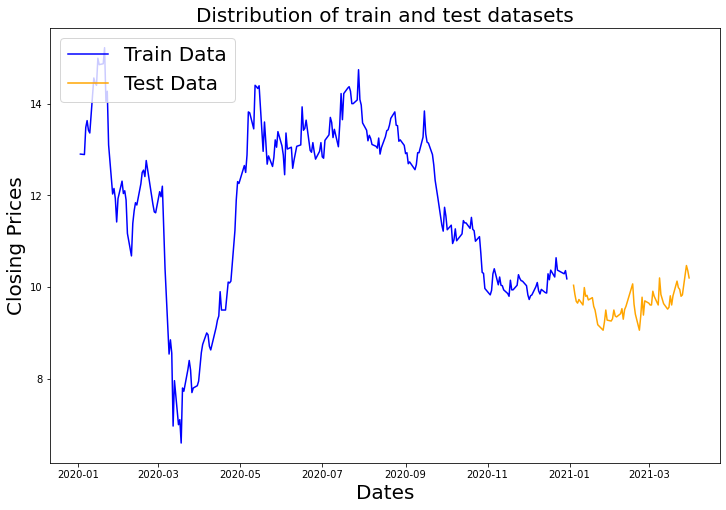

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df_train['Price'],color='blue', label='Train Data')
plt.plot(df_test['Price'],color='orange', label='Test Data')
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Closing Prices',fontsize=20)
plt.legend(loc='upper left',fontsize=20)
plt.title('Distribution of train and test datasets',fontsize=20)
plt.show()

In [20]:
df_train

,Price,Open,High,Low,Difference
Date,,,,,
2020-01-03,12.90,12.45,12.93,12.27,0.33
2020-01-06,12.89,12.90,12.91,12.57,-0.01
2020-01-07,13.48,13.03,13.48,13.03,0.59
2020-01-08,13.63,13.50,13.68,13.18,0.15
2020-01-09,13.42,13.69,13.80,13.26,-0.21
...,...,...,...,...,...
2020-12-22,10.64,10.32,10.78,10.30,0.42
2020-12-23,10.37,10.70,10.79,10.34,-0.27
2020-12-28,10.29,10.41,10.42,10.21,-0.08


In [21]:
df_test

,Price,Open,High,Low,Difference
Date,,,,,
2021-01-04,10.04,10.23,10.32,10.03,-0.14
2021-01-05,9.84,10.07,10.10,9.77,-0.20
2021-01-06,9.69,9.85,9.86,9.69,-0.15
2021-01-07,9.65,9.75,9.81,9.62,-0.04
2021-01-08,9.73,9.67,9.85,9.66,0.08
2021-01-11,9.61,9.70,9.80,9.60,-0.12
2021-01-12,9.99,9.68,10.03,9.62,0.38
2021-01-13,9.80,10.05,10.06,9.68,-0.19
2021-01-14,9.82,9.86,9.96,9.73,0.02


## ARIMA Model

In [22]:
 arima_model = pm.auto_arima(df_train.Price, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [23]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  248
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -122.834
Date:                Thu, 23 Jun 2022   AIC                            259.667
Time:                        12:53:40   BIC                            284.233
Sample:                             0   HQIC                           269.558
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0138      0.045     -0.308      0.758      -0.102       0.074
ar.L1         -0.0259      0.139     -0.187      0.852      -0.298       0.246
ar.L2         -0.5006      0.154     -3.260      0.0

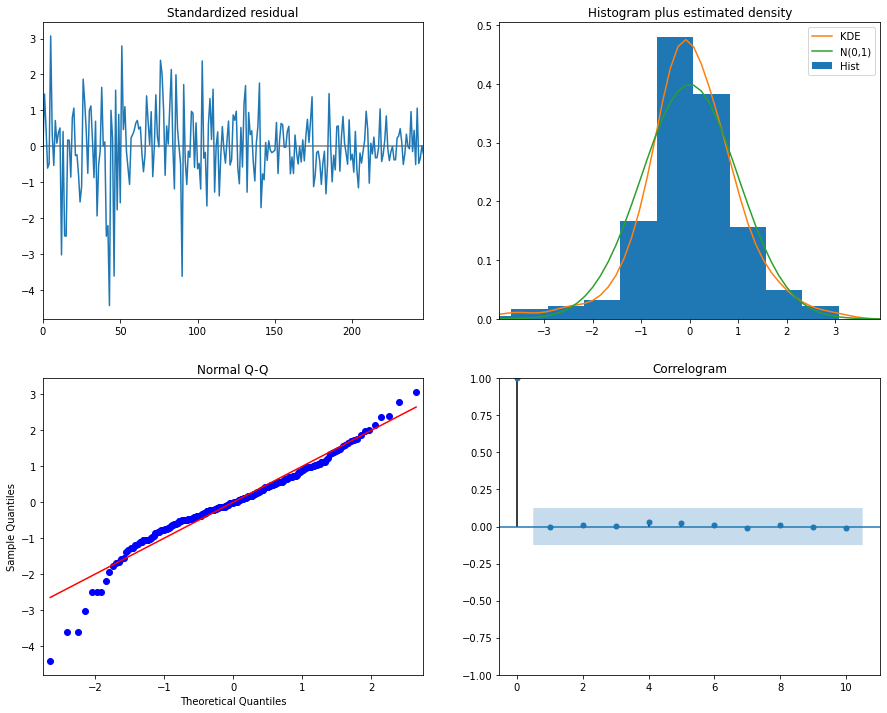

In [24]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [25]:
arima = statsmodels.tsa.arima.model.ARIMA(df_train.Price,order=(3, 1, 2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [26]:
arima_fit = arima.fit()

In [27]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  248
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -122.893
Date:                Thu, 23 Jun 2022   AIC                            257.786
Time:                        12:54:08   BIC                            278.843
Sample:                             0   HQIC                           266.264
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0252      0.138     -0.182      0.855      -0.296       0.246
ar.L2         -0.4993      0.148     -3.367      0.001      -0.790      -0.209
ar.L3          0.1332      0.060      2.202      0.0

In [28]:
y_pred = arima_model.predict(len(df_test['Price']))

In [29]:
y_pred

array([10.13413246, 10.16679863, 10.15127392, 10.11543364, 10.11463673,
       10.11672411, 10.09850557, 10.08400691, 10.07995867, 10.07109021,
       10.05760749, 10.04804031, 10.04004366, 10.02943556, 10.0186271 ,
       10.00933896,  9.99976613,  9.98941309,  9.97942398,  9.96977833,
        9.95983835,  9.94978223,  9.93992191,  9.9300757 ,  9.92011574,
        9.91017758,  9.90029766,  9.89039027,  9.88045732,  9.87054649,
        9.86064424,  9.85072732,  9.84080941,  9.83090001,  9.82098894,
        9.81107352,  9.80116017,  9.79124873,  9.78133563,  9.77142189,
        9.76150925,  9.75159668,  9.74168347,  9.73177039,  9.72185764,
        9.71194473,  9.70203168,  9.69211875,  9.68220587,  9.6722929 ,
        9.66237994,  9.65246702,  9.64255409,  9.63264113,  9.62272819,
        9.61281526,  9.60290232,  9.59298937,  9.58307643,  9.5731635 ])

In [30]:
fc = len(df_test['Price'])
fc_series = pd.Series(y_pred,index=df_test['Price'].index)

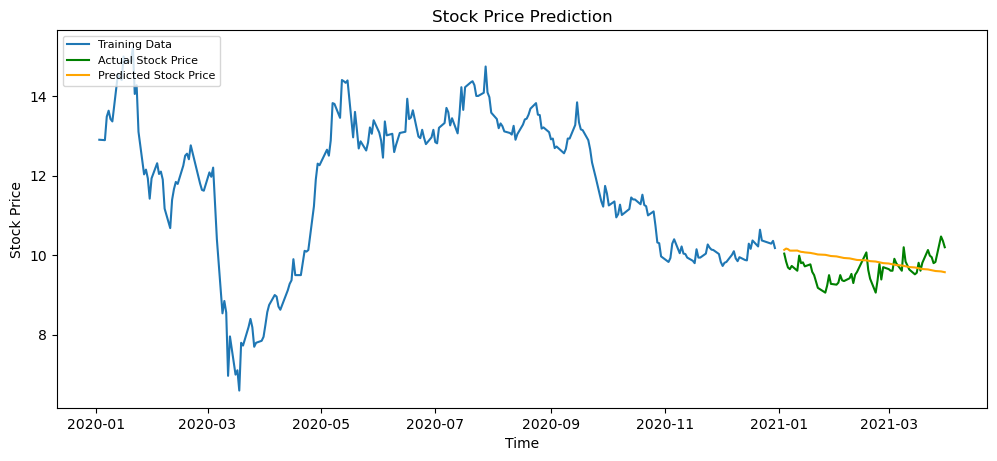

In [31]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df_train.Price,label='Training Data')
plt.plot(df_test.Price,color='green',label='Actual Stock Price')
plt.plot(fc_series,color='orange',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [32]:
fc_series

Date
2021-01-04    10.134132
2021-01-05    10.166799
2021-01-06    10.151274
2021-01-07    10.115434
2021-01-08    10.114637
2021-01-11    10.116724
2021-01-12    10.098506
2021-01-13    10.084007
2021-01-14    10.079959
2021-01-15    10.071090
2021-01-18    10.057607
2021-01-19    10.048040
2021-01-20    10.040044
2021-01-21    10.029436
2021-01-22    10.018627
2021-01-26    10.009339
2021-01-27     9.999766
2021-01-28     9.989413
2021-01-29     9.979424
2021-02-01     9.969778
2021-02-02     9.959838
2021-02-03     9.949782
2021-02-04     9.939922
2021-02-05     9.930076
2021-02-08     9.920116
2021-02-09     9.910178
2021-02-10     9.900298
2021-02-11     9.890390
2021-02-12     9.880457
2021-02-17     9.870546
2021-02-18     9.860644
2021-02-19     9.850727
2021-02-22     9.840809
2021-02-23     9.830900
2021-02-24     9.820989
2021-02-25     9.811074
2021-02-26     9.801160
2021-03-01     9.791249
2021-03-02     9.781336
2021-03-03     9.771422
2021-03-04     9.761509
2021-03-05 

In [33]:
mape = np.mean(np.abs(fc-df_test['Price'])/np.abs(df_test['Price']))
print(mape)

5.217773080710725


In [34]:
 mean_absolute_error(df_test.Price, y_pred)

0.3791494395090505

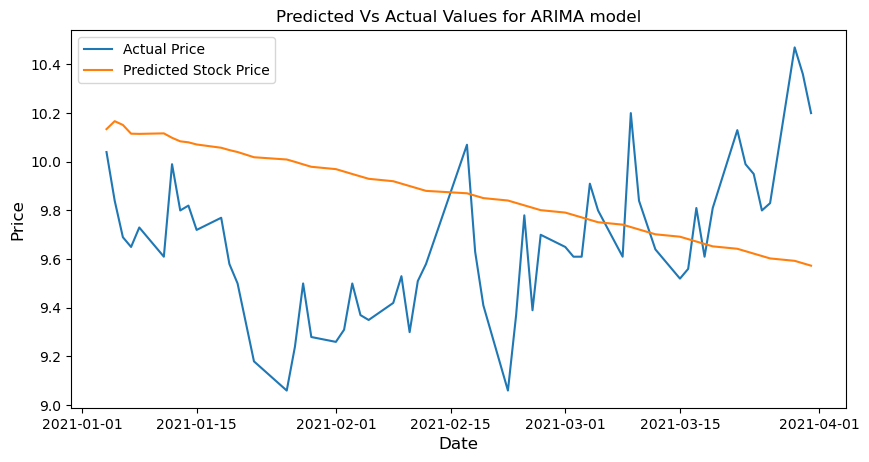

In [35]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(df_test.Price,label='Actual Price')
plt.plot(fc_series,label='Predicted Stock Price')
plt.title('Predicted Vs Actual Values for ARIMA model')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.show()

## Time Series Cross Validation

Observations: 154
Training Observations: 77
Testing Observations: 77


<Figure size 432x288 with 0 Axes>

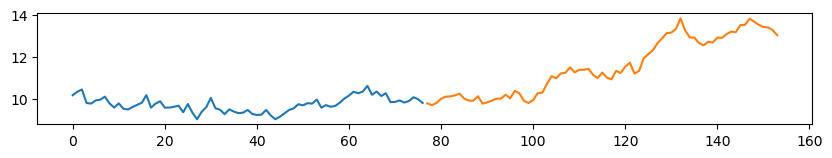

Observations: 231
Training Observations: 154
Testing Observations: 77


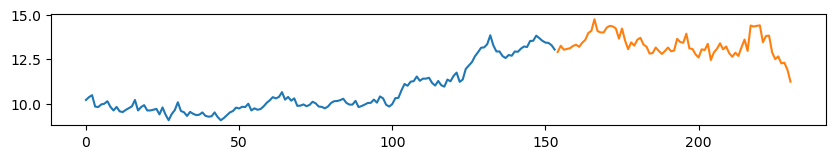

Observations: 308
Training Observations: 231
Testing Observations: 77


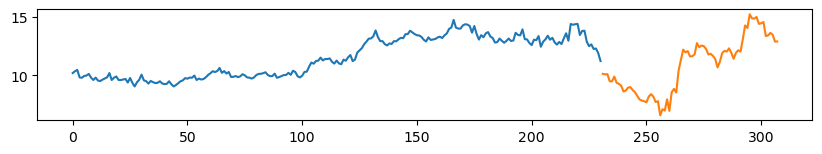

In [36]:

from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = df.Price
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.figure(figsize=(10,5),dpi=100)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
    pyplot.show()

In [37]:
from matplotlib import pyplot

X = df.Price
n_train = 249
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

train=249, test=1
train=250, test=1
train=251, test=1
train=252, test=1
train=253, test=1
train=254, test=1
train=255, test=1
train=256, test=1
train=257, test=1
train=258, test=1
train=259, test=1
train=260, test=1
train=261, test=1
train=262, test=1
train=263, test=1
train=264, test=1
train=265, test=1
train=266, test=1
train=267, test=1
train=268, test=1
train=269, test=1
train=270, test=1
train=271, test=1
train=272, test=1
train=273, test=1
train=274, test=1
train=275, test=1
train=276, test=1
train=277, test=1
train=278, test=1
train=279, test=1
train=280, test=1
train=281, test=1
train=282, test=1
train=283, test=1
train=284, test=1
train=285, test=1
train=286, test=1
train=287, test=1
train=288, test=1
train=289, test=1
train=290, test=1
train=291, test=1
train=292, test=1
train=293, test=1
train=294, test=1
train=295, test=1
train=296, test=1
train=297, test=1
train=298, test=1
train=299, test=1
train=300, test=1
train=301, test=1
train=302, test=1
train=303, test=1
train=304,

In [38]:
x = df_final['Price']
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(3, 1, 2)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-03-31   10.2       10.487753


In [39]:
import warnings
from math import sqrt

# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(3, 1, 2)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-02-17  10.07        9.494693
2021-02-18   9.63       10.053840
2021-02-19   9.41        9.790478
2021-02-22   9.06        9.439644
2021-02-23   9.37        8.891542
2021-02-24   9.78        9.217263
2021-02-25   9.39        9.822527
2021-02-26   9.70        9.591724
2021-03-01   9.65        9.649221
2021-03-02   9.61        9.506276
2021-03-03   9.61        9.648381
2021-03-04   9.91        9.673708
2021-03-05   9.80        9.844757
2021-03-08   9.61        9.789352
2021-03-09  10.20        9.673862
2021-03-10   9.84       10.105321
2021-03-11   9.74        9.867650
2021-03-12   9.64        9.822623
2021-03-15   9.52        9.569084
2021-03-16   9.56        9.437728
2021-03-17   9.81        9.554336
2021-03-18   9.61        9.814171
2021-03-19   9.81        9.655957
2021-03-22  10.13        9.778693
2021-03-23   9.99       10.057257
2021-03-24   9.95       10.070482
2021-03-25   9.80       10.010868
2021-03-26   9

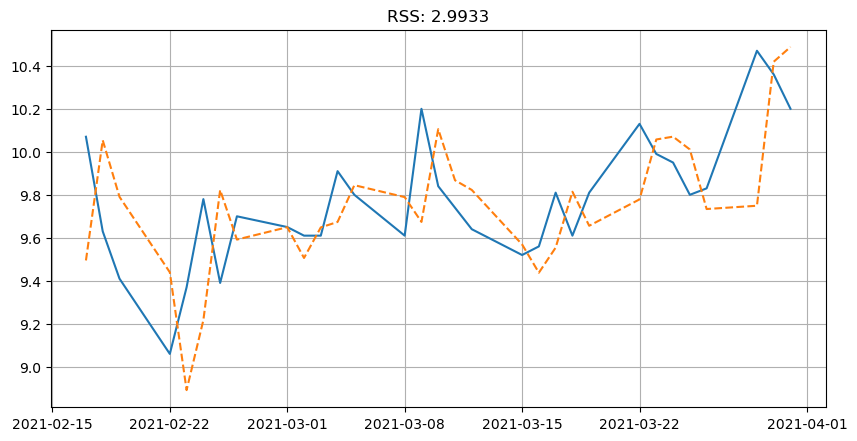

Test RMSE for ARIMA with Walk-Forward Validation:  0.3107363519726906


In [40]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(test_['Price'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Price'])**2))
plt.grid(True);plt.show()
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

In [41]:
mape = np.mean(np.abs(prediction-test.values)/np.abs(test.values))
print(mape)

0.025496037371683794


# LSTM Model

In [42]:
df = timeseries_preprocessing(df_bra)

In [43]:
df

,Date,Price,Open,High,Low
307,2020-01-03,12.90,12.45,12.93,12.27
306,2020-01-06,12.89,12.90,12.91,12.57
305,2020-01-07,13.48,13.03,13.48,13.03
304,2020-01-08,13.63,13.50,13.68,13.18
303,2020-01-09,13.42,13.69,13.80,13.26
...,...,...,...,...,...
4,2021-03-25,9.80,10.01,10.01,9.66
3,2021-03-26,9.83,9.80,9.94,9.70
2,2021-03-29,10.47,9.85,10.50,9.81
1,2021-03-30,10.36,10.41,10.62,10.30


In [44]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [45]:
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

In [46]:
train_test_boundary

60

In [47]:
date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

In [48]:
df = df.set_index('Date')

In [49]:
df

,Price,Open,High,Low,Year
Date,,,,,
2020-01-03,12.90,12.45,12.93,12.27,2020
2020-01-06,12.89,12.90,12.91,12.57,2020
2020-01-07,13.48,13.03,13.48,13.03,2020
2020-01-08,13.63,13.50,13.68,13.18,2020
2020-01-09,13.42,13.69,13.80,13.26,2020
...,...,...,...,...,...
2021-03-25,9.80,10.01,10.01,9.66,2021
2021-03-26,9.83,9.80,9.94,9.70,2021
2021-03-29,10.47,9.85,10.50,9.81,2021


In [50]:
#removing the Year column
df = df.drop(columns = ['Year'])

In [51]:
#global variables
n_steps = 3
n_features = 1


In [52]:
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

In [53]:
#defining the training dataframe
train_df = df[:-train_test_boundary]
    
#defining the testing dataframe
test_df = df[-train_test_boundary:]

In [54]:
train_df.shape

(248, 4)

In [55]:
test_df.shape

(60, 4)

In [56]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

In [57]:
#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [58]:
X_train.shape,y_train.shape

((245, 3, 1), (245,))

In [59]:
X_test.shape,y_test.shape

((57, 3, 1), (57,))

In [60]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [61]:
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [62]:
df_final

,Actual Price,Predicted Price
Date,,
2020-01-08,13.63,12.986390
2020-01-09,13.42,13.212258
2020-01-10,13.36,13.446778
2020-01-13,14.56,13.430354
2020-01-14,14.45,13.614905
...,...,...
2021-03-25,9.80,10.032887
2021-03-26,9.83,9.941697
2021-03-29,10.47,9.877775


In [63]:
#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

Root Mean Squared Error is 0.485666394091003


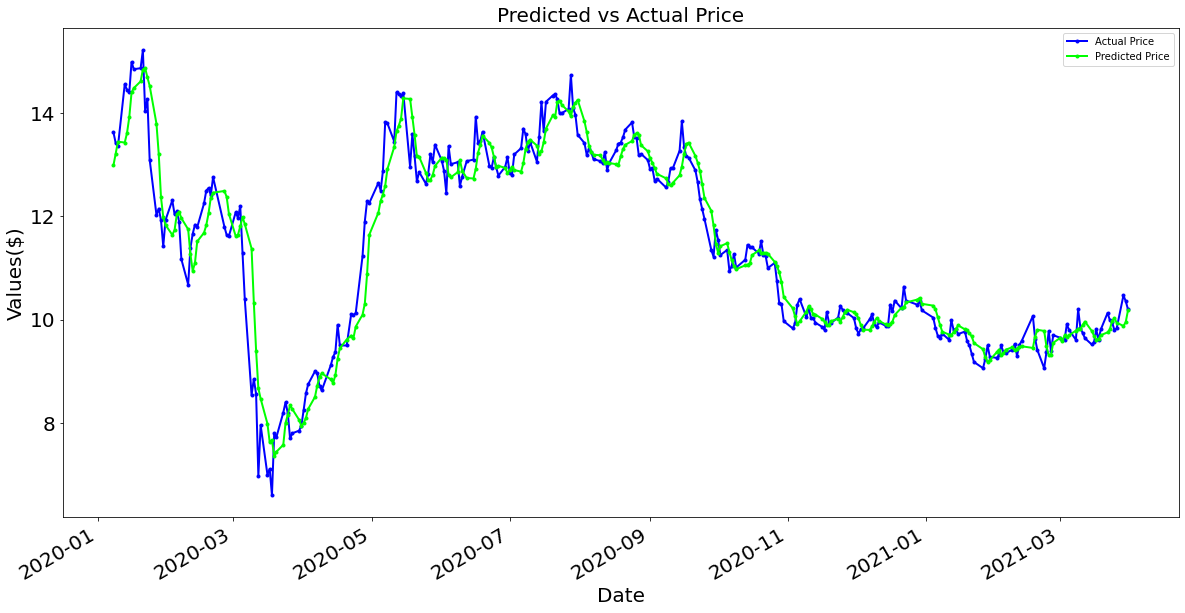

In [64]:
df_final[['Actual Price','Predicted Price']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
plt.xlabel('Date',fontsize=20);
plt.ylabel('Values($)',fontsize=20);
plt.title('Predicted vs Actual Price',fontsize = 20)
plt.show() 

<Figure size 432x288 with 0 Axes>

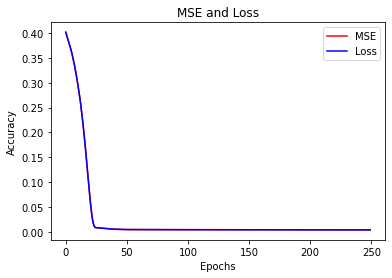

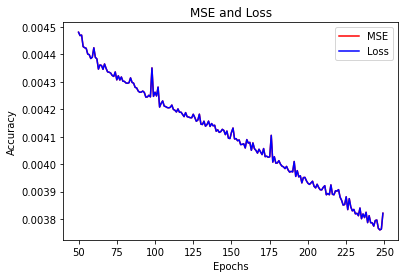

<Figure size 432x288 with 0 Axes>

In [65]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])


plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()


In [66]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [67]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)
        
        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $80755.53999999975 with sma of 30 using a bollinger parameter 40


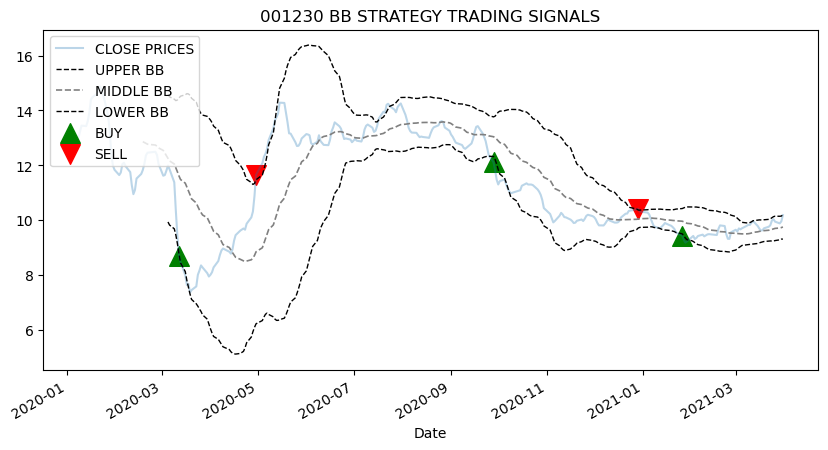

In [68]:
df_final['sma'] = sma(df_final['Predicted Price'], 30)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 40)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)
plt.figure(figsize=(10,5),dpi=100)
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('001230 BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()